In [7]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from wbfm.utils.projects.finished_project_data import ProjectData
import napari
import pandas as pd
import numpy as np
import argparse
from torch.utils.data import DataLoader
from fDNC.src.model import NIT_Registration, neuron_data_pytorch
import torch
import math
import time
import os
import numpy as np
from tqdm.auto import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
fname = "/home/charles/dlc_stacks/worm3-newseg-2021_11_17/project_config.yaml"
project_data = ProjectData.load_final_project_data_from_config(fname, to_load_tracklets=True)

Output files: /home/charles/dlc_stacks/worm3-newseg-2021_11_17/3-tracking/manual_annotation/global2tracklet_manual.pickle, /home/charles/dlc_stacks/worm3-newseg-2021_11_17/3-tracking/manual_annotation/manually_split_tracklets.h5, /home/charles/dlc_stacks/worm3-newseg-2021_11_17/3-tracking/manual_annotation/split_names.pickle, /home/charles/dlc_stacks/worm3-newseg-2021_11_17/3-tracking/manual_annotation/split_times.pickle
Project data for directory:
/home/charles/dlc_stacks/worm3-newseg-2021_11_17 
Found the following raw data files:
red_data: True
green_data: True
============Segmentation===============
raw_segmentation: True
segmentation: True
============Tracklets==================
df_training_tracklets: False
reindexed_masks_training: True
============Traces=====================
red_traces: True
green_traces: True
final_tracks: True
behavior_annotations: True



# Look at the data as returned by the data loader

In [51]:
DATA_PATH="/home/charles/Current_work/repos/fDNC_Neuron_ID/Data"
train_path = f"{DATA_PATH}/train_synthetic" 
eval_path = f"{DATA_PATH}/validation_synthetic"

model_path = "/home/charles/Current_work/repos/fDNC_Neuron_ID/fDNC/model/model.bin"

batch_size = 64
data_mode = 'all'

n_hidden = 128
f_trans = 0
p_rotate = 0
n_layer = 6

In [52]:

# loading the data
train_data = neuron_data_pytorch(train_path, batch_sz=batch_size, shuffle=True, rotate=True, mode=data_mode)
dev_data = neuron_data_pytorch(eval_path, batch_sz=batch_size, shuffle=False, rotate=True, mode=data_mode)


total volumes:236800
total volumes:12800


In [53]:

train_data_loader = DataLoader(train_data, shuffle=False, num_workers=1, collate_fn=train_data.custom_collate_fn)
dev_data_loader = DataLoader(dev_data, shuffle=False, num_workers=1, collate_fn=dev_data.custom_collate_fn)
# device = torch.device(f"cuda:{args.cuda_device_index}" if cuda else "cpu")
model = NIT_Registration(input_dim=3, n_hidden=n_hidden, n_layer=n_layer, p_rotate=p_rotate,
                             feat_trans=f_trans, cuda=False)

In [54]:

params = torch.load(model_path, map_location=lambda storage, loc: storage)
model.load_state_dict(params['state_dict'])

<All keys matched successfully>

In [130]:

for data_batch in dev_data_loader:
    # print(t)
    pt_batch = data_batch['pt_batch']
    match_dict = data_batch['match_dict']
    ref_idx=data_batch['ref_i']
    
    batch_loss, out = model(pt_batch, match_dict=match_dict, ref_idx=ref_idx , mode='eval')
    break


In [131]:
out.keys()

dict_keys(['p_m', 'paired_idx'])

In [132]:
# match_dict[1]

In [133]:
out['p_m'].shape

torch.Size([64, 115, 108])

In [134]:
i_worm = 1

for match, gt in zip(out['paired_idx'][i_worm], match_dict[i_worm]):
    print(gt, match)

[ 0 19] tensor(18)
[ 1 40] tensor(37)
[ 2 39] tensor(12)
[ 3 82] tensor(39)
[ 4 23] tensor(32)
[ 5 15] tensor(79)
[ 6 76] tensor(81)
[ 7 33] tensor(106)
[ 8 91] tensor(78)
[ 9 83] tensor(20)
[ 10 105] tensor(35)
[11 90] tensor(14)
[12  2] tensor(104)
[13 28] tensor(62)
[14 11] tensor(64)
[15 18] tensor(5)
[17 70] tensor(102)
[18  0] tensor(11)
[19 78] tensor(15)
[20  9] tensor(0)
[21 43] tensor(84)
[23 47] tensor(95)
[24 25] tensor(61)
[25 75] tensor(4)
[26 67] tensor(57)
[28 77] tensor(24)
[29 65] tensor(7)
[30 81] tensor(88)
[31 79] tensor(13)
[32 92] tensor(42)
[33 74] tensor(98)
[34 51] tensor(75)
[35 10] tensor(6)
[36 85] tensor(7)
[37  1] tensor(85)
[38 54] tensor(69)
[39  3] tensor(63)
[40 73] tensor(67)
[41 42] tensor(49)
[42 29] tensor(2)
[ 44 106] tensor(1)
[45 41] tensor(45)
[46 48] tensor(41)
[47 32] tensor(21)
[49 38] tensor(80)
[50 87] tensor(99)
[51 68] tensor(56)
[52 55] tensor(23)
[ 53 101] tensor(46)
[54 52] tensor(58)
[ 55 104] tensor(97)
[56 46] tensor(34)
[57 24] t

In [173]:
pt_batch[0][:3]

array([[ 0.283118  , -0.09438682,  0.01846974],
       [-0.20458283,  0.0908309 , -0.08002971],
       [ 0.18982178, -0.16600474,  0.05017817]])

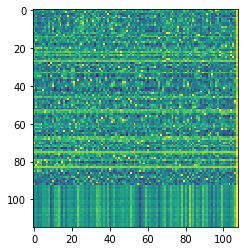

In [60]:

i_worm = 3
plt.imshow(out['p_m'][i_worm].detach().numpy())

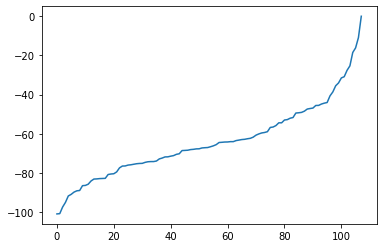

In [179]:
# Look at sorted similarity for individual neurons

i_worm = 3
i_neuron = 20

all_dist = out['p_m'][i_worm].detach().numpy()
this_dist = all_dist[i_neuron]
this_dist.sort()
plt.plot(this_dist)

In [73]:
# TODO: should match to ref_idx
# i_worm = 1

# for m, p in zip(match_dict[i_worm], out['paired_idx'][i_worm]):
#     is_match = p.numpy()==m[1]
    
#     print(m, is_match)
#     if not is_match:
#         print(p)

In [162]:
from wbfm.utils.visualization.visualization_tracks import visualize_tracks, visualize_tracks_two_matches

In [163]:
i_worm = 15

neurons0 = pt_batch[0]
neurons1 = pt_batch[i_worm]

In [164]:

matches_gt = match_dict[i_worm][:, [1,0]]
visualize_tracks(neurons0, neurons1, matches)

[LineSet with 96 lines.,
 PointCloud with 107 points.,
 PointCloud with 107 points.]

In [165]:

matches_nn = [[i, m] for i, m in enumerate(out['paired_idx'][i_worm])]
visualize_tracks(neurons0, neurons1, matches)

[LineSet with 96 lines.,
 PointCloud with 107 points.,
 PointCloud with 107 points.]

In [180]:
visualize_tracks_two_matches(neurons0, neurons1, matches_gt, matches_nn)

(LineSet with 97 lines., LineSet with 108 lines.)

In [155]:
ref_idx

0

# Do encoding step by step

In [76]:
pts = data_batch['pt_batch']

pts_lengths = [len(s) for s in pts]
# pts_padded should be of dimension (
pts_padded = model.to_input_tensor(pts)
pts_encode = model.encode(pts_padded, pts_lengths, ref_idx)

In [81]:
# pts_encode has the reference points appended
pts_encode[0].shape, pts[0].shape, pts_padded[0].shape

(torch.Size([222, 128]), (107, 3), torch.Size([115, 3]))

In [82]:

ref_emb = pts_encode[:, :pts_lengths[ref_idx], :]
mov_emb = pts_encode[:, pts_lengths[ref_idx]:, :]

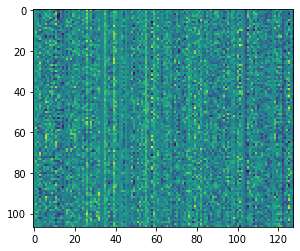

In [87]:
# Look at the embeddings

i = 0
plt.imshow(ref_emb[i].detach().numpy())

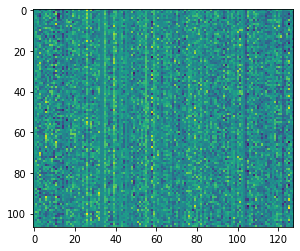

In [88]:

i = 0
plt.imshow(ref_emb[i].detach().numpy())


# To what is the transformer actually applied?

In [101]:
pts_length = [len(s) for s in pts]

pts_proj = model.point_f(pts_padded.transpose(2, 1))
pts_proj = pts_proj.transpose(2, 1)

mask = model.generate_sent_masks(pts_proj, pts_length)
# append the ref points to each batch
ref_pts_proj = pts_proj[ref_idx:ref_idx + 1, :pts_length[ref_idx], :]
mask_ref = torch.zeros((mask.size(0), pts_length[ref_idx]), dtype=torch.float, device=mask.device).bool()

# simply add 1 to the ref
ref_pts_proj = torch.repeat_interleave(ref_pts_proj, repeats=pts_proj.size(0), dim=0) + 1

pts_proj = torch.cat((ref_pts_proj, pts_proj), dim=1)
mask = torch.cat((mask_ref, mask), dim=1)

pts_encode = model.model(pts_proj.transpose(dim0=0, dim1=1), src_key_padding_mask=mask)

pts_encode = pts_encode.transpose(dim0=0, dim1=1)

In [105]:

# The arg of the transformer
arg = pts_proj.transpose(dim0=0, dim1=1)
arg.shape, pts_encode.shape

(torch.Size([222, 64, 128]), torch.Size([64, 222, 128]))

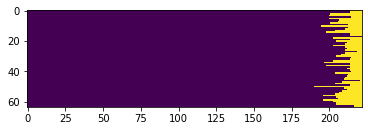

In [113]:
plt.imshow(mask)

# Are the reference postures aligned between batches?

In [181]:
all_pts = []
all_matches = []
for i, data_batch in enumerate(dev_data_loader):
    all_pts.append(data_batch['pt_batch'])
    all_matches.append(data_batch['match_dict'])
    ref_idx=data_batch['ref_i']
    print(ref_idx)
    
    # batch_loss, out = model(pt_batch, match_dict=match_dict, ref_idx=ref_idx , mode='eval')
    if i > 0:
        break


0
0


In [182]:
# Get reference postures for both batches
b0_n0 = all_pts[0][0]
b1_n0 = all_pts[1][0]

# Get the matches (which should be identity)
b0_m0 = all_matches[0][0]
b1_m0 = all_matches[1][0]

In [185]:
visualize_tracks_two_matches(b0_n0, b1_n0, b0_m0, b1_m0)

(LineSet with 105 lines., LineSet with 67 lines.)